In [209]:
import numpy as np
import pandas as pd
import os
import pymatgen as mg
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

from matminer.featurizers.composition import ElementProperty

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline

from citrination_client import CitrinationClient, PifSystemReturningQuery, DataQuery, DatasetQuery, Filter


from helpers.calc_chemfeat_2 import Perovskite
from helpers.featurizers import PerovskiteProperty
from helpers.feature_select import rank_correlation, get_linked_groups
import helpers.model_eval as mv

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# I. Load data

In [2]:
client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')

In [3]:
# Get all pifs from dataset
ds_id = '176703'

query = PifSystemReturningQuery(
            query=DataQuery(
                dataset=DatasetQuery(
                    id=Filter(equal=ds_id)
                )
            )
        )

results = client.search.pif_search(query)
formulas = [hit.system.chemical_formula for hit in results.hits]
conductivities = [float(hit.as_dictionary()['system']['properties'][0]['scalars'][0]['value']) for hit in results.hits]

# Convert to compositions. Store unreadable formulas for inspection later
def is_bad_formula(formula):
    try:
        mg.Composition(formula)
        return False
    except mg.core.composition.CompositionError:
        return True


compositions = [mg.Composition(f) for f in formulas if is_bad_formula(f)==False]
bad_formulas = [f for f in formulas if is_bad_formula(f)]

Citrination Client Warning - Query size greater than max system size - only 10000 results will be returned


## Data validation/analysis

In [4]:
bad_formulas

['SrSc0.5Al0 45Y0 05Al0 5 . . .O2.5',
 'BaGd0.5In0 3Ga0.2Al0 5 . . O',
 'BaGd0.5In0 4Ga0.1Al0 5 . . O',
 'BaIn0.8Ca0.1Zr0.1Al0.5 O2 5']

In [5]:
# Check for multivalent cations
unique_elements = np.unique(sum([c.elements for c in compositions],[]))
multivalent_elements = unique_elements[np.where(np.array([len(el.common_oxidation_states) for el in unique_elements]) > 1)]
dict(zip(multivalent_elements,[el.common_oxidation_states for el in multivalent_elements]))

{Element Si: (-4, 4)}

In [261]:
# get oxidation state of each cation in dataset for reference
def cation_ox_state(el):
    "only positive oxidation states"
    pos_states = [ox for ox in el.common_oxidation_states if ox > 0]
    if len(pos_states)==1:
        return pos_states[0]
    elif len(pos_states) > 1:
        raise ValueError('Multiple positive oxidation states')
    elif len(pos_states)==0:
        raise ValueError('No positive oxidation states')

cation_ox_states = dict(zip(unique_elements,[cation_ox_state(el) for el in unique_elements if el.name!='O']))
cation_ox_states

{Element Ba: 2,
 Element Sr: 2,
 Element Ca: 2,
 Element La: 3,
 Element Yb: 3,
 Element Nd: 3,
 Element Sm: 3,
 Element Gd: 3,
 Element Y: 3,
 Element Lu: 3,
 Element Mg: 2,
 Element Zr: 4,
 Element Sc: 3,
 Element Ti: 4,
 Element Be: 2,
 Element Al: 3,
 Element Zn: 2,
 Element In: 3,
 Element Ga: 3,
 Element Si: 4,
 Element Ni: 2}

(array([66.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.]),
 array([2.  , 2.05, 2.1 , 2.15, 2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 ]),
 <a list of 10 Patch objects>)

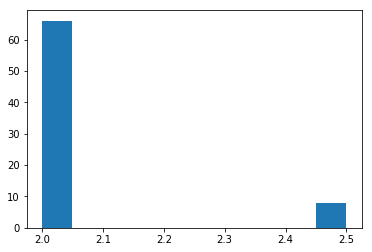

In [7]:
# Check number of cation atoms
cation_amt = np.array([round(c.num_atoms - c.get('O'),4) for c in compositions])
plt.hist(cation_amt)

In [8]:
#filter to compositions with 2 cation units
good_cation_compositions = np.array([c for c in compositions if round(c.num_atoms - c.get('O'),4)==2])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 65.]),
 array([-1.3 , -1.17, -1.04, -0.91, -0.78, -0.65, -0.52, -0.39, -0.26,
        -0.13,  0.  ]),
 <a list of 10 Patch objects>)

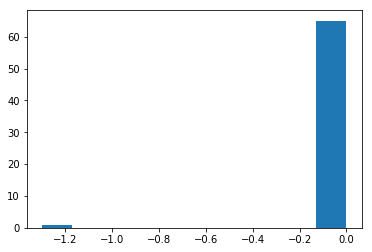

In [290]:
# check net charge
def oxide_net_charge(comp):
    cation_charge = sum([comp[el]*cation_ox_state(el) for el in comp.elements if el.name!='O'])
    return cation_charge - 2*comp['O']

net_charge = np.round([oxide_net_charge(c) for c in good_cation_compositions],4)
comp_charge = dict(zip(good_cation_compositions,net_charge))

plt.hist(net_charge)

In [293]:
dict(zip(good_cation_compositions[np.where(net_charge!=0)],net_charge[np.where(net_charge!=0)]))

{Comp: Sr1 Mg0.1 Sc0.5 Al0.4 O2.475: -0.05, Comp: Ba1 Zr0.3 In0.7 O3.3: -1.3}

In [268]:
# look at A-site and B-site oxidation states

A_site_ox = np.empty(len(good_cation_compositions))
B_site_ox = np.empty(len(good_cation_compositions))
A_site_sum = np.empty(len(good_cation_compositions))
B_site_sum = np.empty(len(good_cation_compositions))

for i,comp in enumerate(good_cation_compositions):
    p = Perovskite.from_ordered_formula(comp.formula)
    A_site_ox[i] = p.site_mean_func('A',cation_ox_state)
    B_site_ox[i] = p.site_mean_func('B',cation_ox_state)
    A_site_sum[i] = p.site_sum('A')
    B_site_sum[i] = p.site_sum('B')

Text(0, 0.5, 'Count')

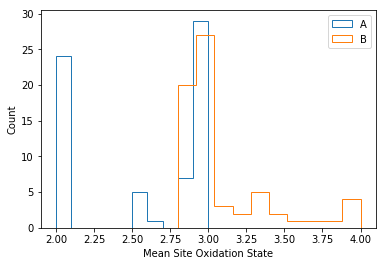

In [269]:
fig, ax = plt.subplots()
ax.hist(A_site_ox,histtype='step',label='A')
ax.hist(B_site_ox,histtype='step',label='B')
ax.legend()
ax.set_xlabel('Mean Site Oxidation State')
ax.set_ylabel('Count')

(array([ 7.,  5.,  1.,  2.,  1.,  1.,  8.,  4.,  9., 28.]),
 array([4.85 , 4.965, 5.08 , 5.195, 5.31 , 5.425, 5.54 , 5.655, 5.77 ,
        5.885, 6.   ]),
 <a list of 10 Patch objects>)

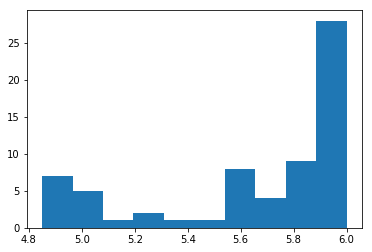

In [271]:
# total cation charge
plt.hist(A_site_ox+B_site_ox)

(array([ 0.,  0., 66.,  0.]),
 array([0.9 , 0.95, 1.  , 1.05, 1.1 ]),
 <a list of 1 Patch objects>)

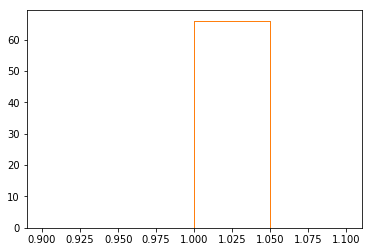

In [289]:
# site occupancies
bins = np.arange(0.9,1.101,0.05)
fig, ax = plt.subplots()
ax.hist(np.round(A_site_sum,5),bins=bins,histtype='step')
ax.hist(B_site_sum,bins=bins,histtype='step')

In [12]:
# check impact of changing oxygen amount
tc = mg.Composition('BaZr0.6In0.4O2.8')
tc2 = mg.Composition('BaZr0.6In0.4O3')

cation_site = {'Ba':'A','Zr':'B','In':'B'}

p = Perovskite(tc,cation_site)
p2 = Perovskite(tc2,cation_site)

In [13]:
feat = p.featurize()
feat2 = p2.featurize()

In [14]:
"need to fix H_formation calculation to account for anion_delta"
feat[feat.round(5)!=feat2.round(5)]

Xsite_oxmin_tot_charge         -5.60
Xsite_oxmax_tot_charge         -5.60
Xsite_oxmean_tot_charge        -5.60
Xsite_oxmedian_tot_charge      -5.60
comp_oxmin_H_formation      -1393.76
comp_oxmax_H_formation      -1393.76
comp_oxmean_H_formation     -1393.76
comp_oxmedian_H_formation   -1393.76
Xsite_num_atoms                 2.80
dtype: float64

In [15]:
feat2[feat.round(5)!=feat2.round(5)]

Xsite_oxmin_tot_charge         -6.000
Xsite_oxmax_tot_charge         -6.000
Xsite_oxmean_tot_charge        -6.000
Xsite_oxmedian_tot_charge      -6.000
comp_oxmin_H_formation      -1343.926
comp_oxmax_H_formation      -1343.926
comp_oxmean_H_formation     -1343.926
comp_oxmedian_H_formation   -1343.926
Xsite_num_atoms                 3.000
dtype: float64

# II. Featurize compositions

In [53]:
# set up filter to define which formulas are used in the model
def formula_filter(formula):
    try:
        comp = mg.Composition(formula)
        if round(comp.num_atoms - comp.get('O'),4)==2:
            return True
        else:
            return False
    except mg.core.composition.CompositionError:
        return False
    
model_records = [(f,c) for f,c in zip(formulas,conductivities) if formula_filter(f)]


In [21]:
# Check A and B site elements
csites = [Perovskite.from_ordered_formula(f).cation_site for f in featurize_formulas]
A_site_elements = np.unique(sum([[k for k,v in cs.items() if v=='A'] for cs in csites],[]))
B_site_elements = np.unique(sum([[k for k,v in cs.items() if v=='B'] for cs in csites],[]))
A_site_elements, B_site_elements

(array(['Ba', 'Ca', 'Gd', 'La', 'Nd', 'Sm', 'Sr', 'Y', 'Yb'], dtype='<U2'),
 array(['Al', 'Be', 'Ca', 'Ga', 'In', 'Lu', 'Mg', 'Ni', 'Sc', 'Si', 'Ti',
        'Y', 'Zn', 'Zr'], dtype='<U2'))

In [22]:
# Elements on both A and B sites in different compositions
np.intersect1d(A_site_elements,B_site_elements)

array(['Ca', 'Y'], dtype='<U2')

In [215]:
# dfs to feed various featurizers
df = pd.DataFrame(model_records,columns=['formula','log_sigma'])
cdf = pd.DataFrame([(mg.Composition(r[0]),r[1]) for r in model_records],columns=['composition','log_sigma'])

In [229]:
# perovksite feature library
pp = PerovskiteProperty.ordered_formula_featurizer(site_base_ox={'A':2.5,'B':3.5,'X':-2})
pp.set_featurize_options(sites=['A','B','comp'],ox_stats=['mean'],silent=False)
pvsk_df = pp.featurize_dataframe(df,col_id='formula',inplace=False)

HBox(children=(IntProgress(value=0, description='PerovskiteProperty', max=66, style=ProgressStyle(description_width='initial')), HTML(value='')))

In [216]:
# magpie library
ep = ElementProperty.from_preset('magpie')
ep_df = ep.featurize_dataframe(cdf,col_id='composition',inplace=False)

HBox(children=(IntProgress(value=0, description='ElementProperty', max=66, style=ProgressStyle(description_width='initial')), HTML(value='')))

In [217]:
ep_df.head()

,composition,log_sigma,minimum Number,maximum Number,range Number,mean Number,avg_dev Number,mode Number,minimum MendeleevNumber,maximum MendeleevNumber,...,range GSmagmom,mean GSmagmom,avg_dev GSmagmom,mode GSmagmom,minimum SpaceGroupNumber,maximum SpaceGroupNumber,range SpaceGroupNumber,mean SpaceGroupNumber,avg_dev SpaceGroupNumber,mode SpaceGroupNumber
0,"(Ba, Zr, In, O)",-3.10,8.0,56.0,48.0,25.416667,20.319444,8.0,9.0,87.0,...,0.0,0.0,0.0,0.0,12.0,229.0,217.0,90.541667,91.631944,12.0
1,"(La, Sr, Ga, Zr, O)",-2.00,8.0,57.0,49.0,21.306122,15.750104,8.0,8.0,87.0,...,0.0,0.0,0.0,0.0,12.0,225.0,213.0,70.877551,71.656810,12.0
2,"(La, Sr, In, O)",-2.03,8.0,57.0,49.0,25.797980,21.213754,8.0,8.0,87.0,...,0.0,0.0,0.0,0.0,12.0,225.0,213.0,75.050505,75.151107,12.0
3,"(Nd, Sr, Ga, O)",-2.73,8.0,60.0,52.0,22.707071,17.529640,8.0,8.0,87.0,...,0.0,0.0,0.0,0.0,12.0,225.0,213.0,59.898990,57.091725,12.0
4,"(Nd, Ba, Al, O)",-4.09,8.0,60.0,52.0,19.434343,16.228548,8.0,9.0,87.0,...,0.0,0.0,0.0,0.0,12.0,229.0,217.0,92.505051,95.955515,12.0


# III. Train and cross-validate models

## A. Pre-modeling data analysis

### Conductivity distribution

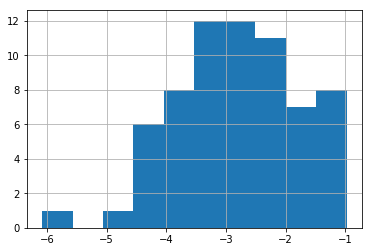

In [60]:
df['log_sigma'].hist()

### Feature correlations and pairplots

#### Magpie library

In [219]:
# sort features by correlation with response
magpie_srt_cols = rank_correlation(ep_df.drop('composition',axis=1),'log_sigma')
magpie_srt_cols_d = rank_correlation(ep_df.drop('composition',axis=1),'log_sigma',corr_type='distance')

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\jdhuang\OneDrive - Colorado School of Mines\python\misc_modules\dcor.py:37: RuntimeWarning:

invalid value encountered in double_scalars



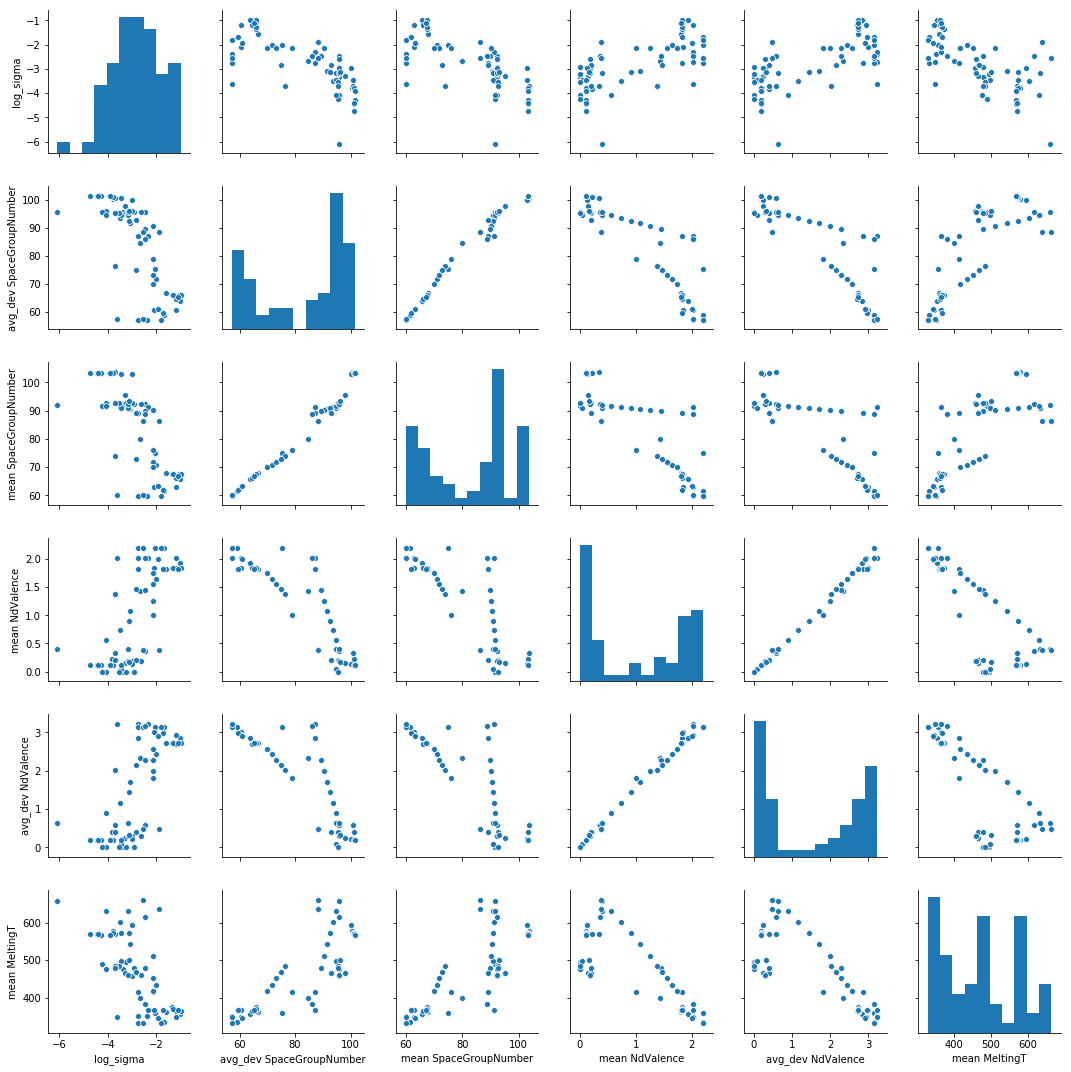

In [220]:
# pairplots of top 5 features vs. response and each other
sn.pairplot(ep_df,vars=['log_sigma'] + list(magpie_srt_cols[:5]))

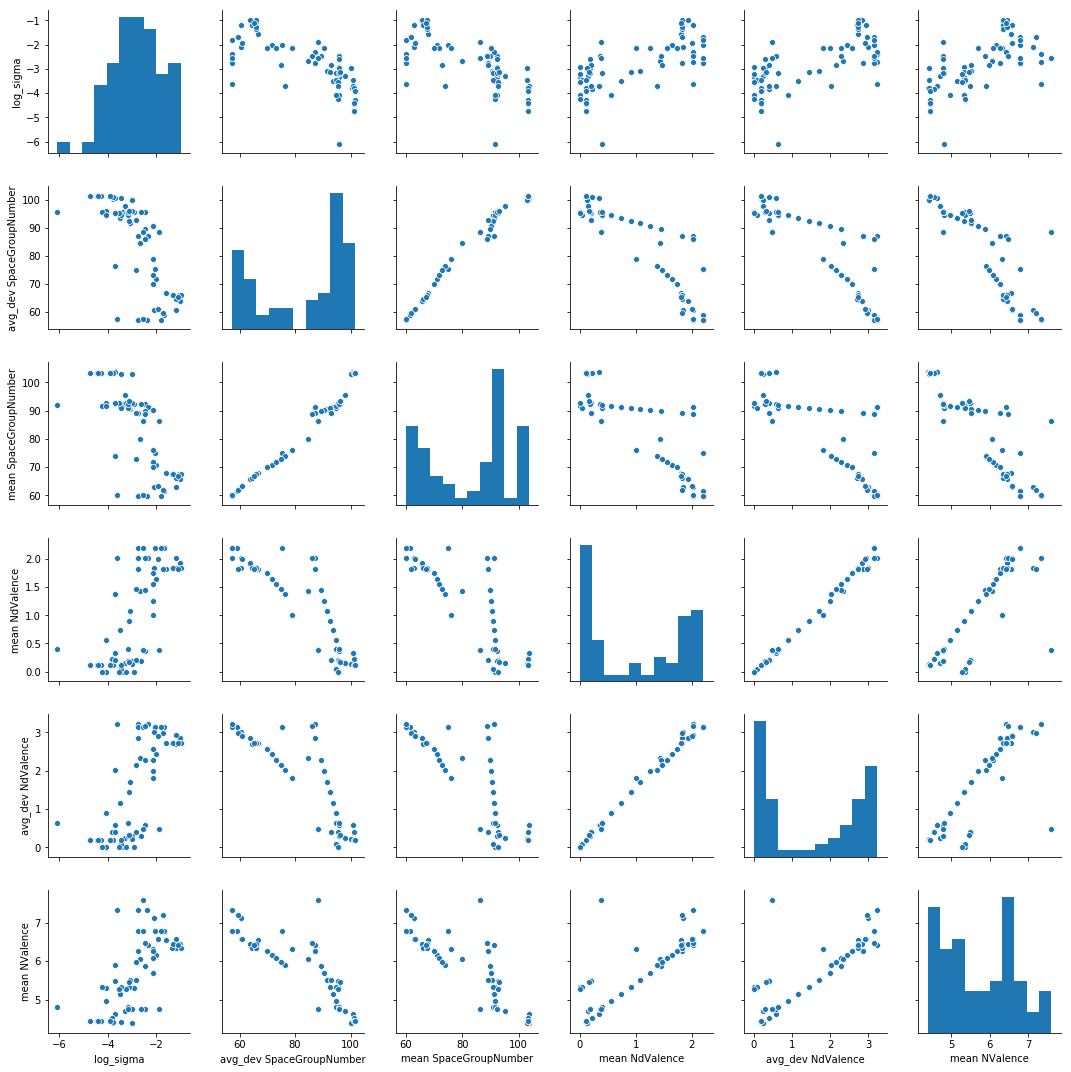

In [221]:
# pairplots of top 5 features vs. response and each other
sn.pairplot(ep_df,vars=['log_sigma'] + list(magpie_srt_cols_d[:5]))

#### Perovskite library

In [218]:
# fcorr = np.corrcoef(pvsk_df.drop(['formula','log_sigma'],axis=1),rowvar=False)
# get_linked_groups(fcorr,0.99)

In [125]:
# sort features by correlation with response
srt_cols = rank_correlation(pvsk_df.drop('formula',axis=1),'log_sigma')
srt_cols_d = rank_correlation(pvsk_df.drop('formula',axis=1),'log_sigma',corr_type='distance')

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\jdhuang\OneDrive - Colorado School of Mines\python\misc_modules\dcor.py:37: RuntimeWarning:

invalid value encountered in double_scalars



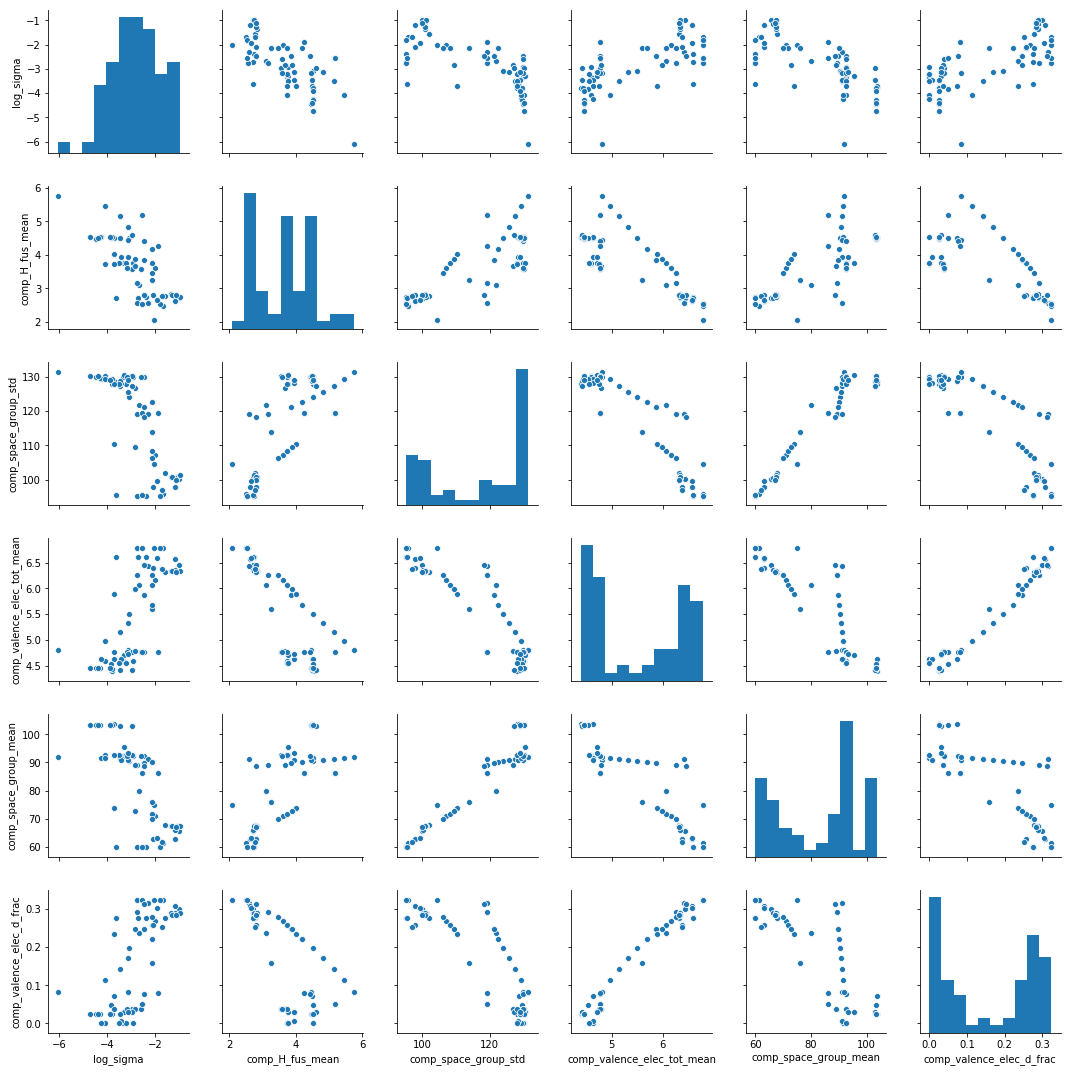

In [226]:
# pairplots of top 5 features vs. response and each other (Pearson correlation)
sn.pairplot(pvsk_df,vars=['log_sigma'] + list(srt_cols[:5]))

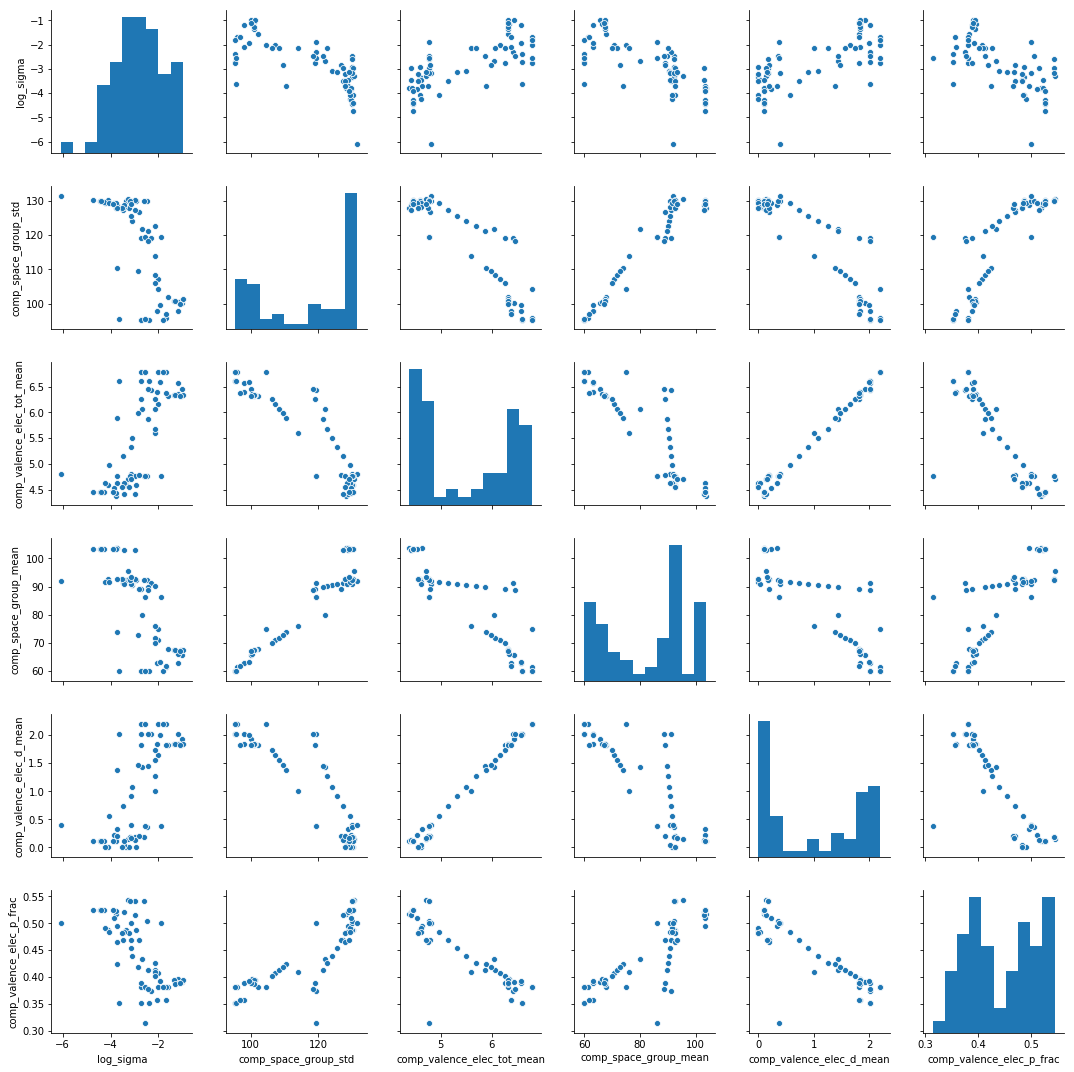

In [126]:
# pairplots of top 5 features vs. response and each other (distance correlation)
sn.pairplot(pvsk_df,vars=['log_sigma'] + list(srt_cols_d[:5]))

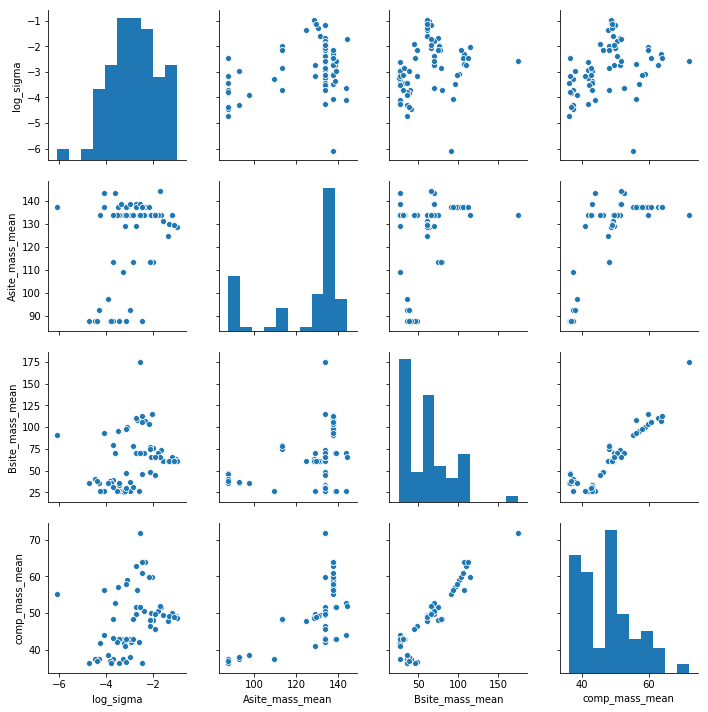

In [257]:
# pairplots of base feature split into sites
#base_feat = 'oxmean_MX_ABE' # B site most correlated
#base_feat = 'valence_elec_tot_mean' # B site main contributor
#base_feat = 'space_group_std' #comp most correlated; opposite trend to A and B sites
#base_feat = 'oxmean_r_mean' #not much
#base_feat = 'oxmean_r_std' #some correlation in B
#base_feat = 'oxmean_goldschmidt' #comp correlation
#base_feat = 'oxmean_X_cat_mean' # some corrrelation in B
#base_feat = 'oxmean_X_cat_std' # comp most correlated
#base_feat = 'MX_IC_mean' # B most correlated
#base_feat = 'X_mean' #B most correlated

sites = ['Asite','Bsite','comp']
pair_cols = [f'{site}_{base_feat}' for site in sites]
sn.pairplot(pvsk_df,vars=['log_sigma'] + pair_cols)

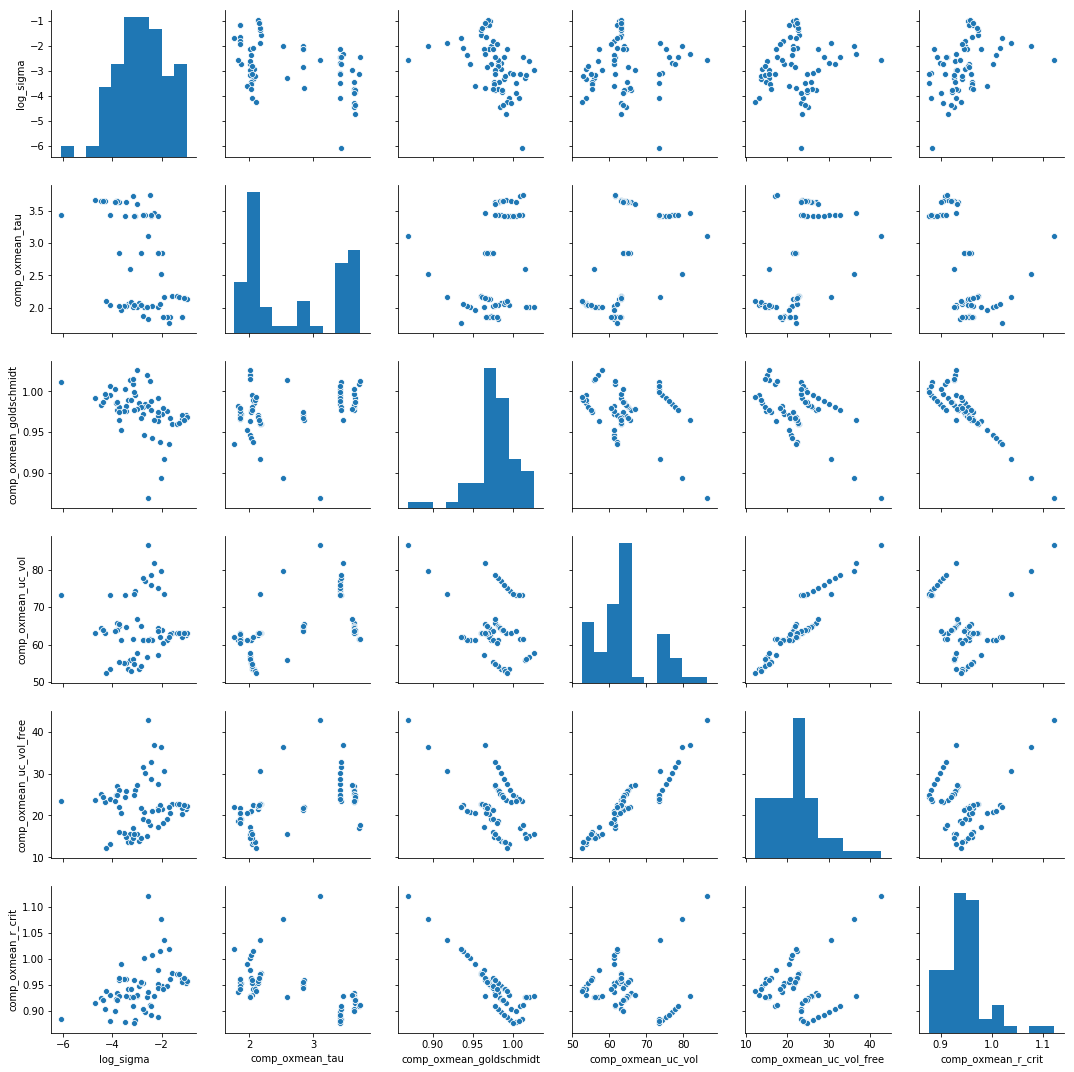

In [259]:
# pairplots of composition-level features
pair_cols = ['comp_oxmean_tau','comp_oxmean_goldschmidt','comp_oxmean_uc_vol','comp_oxmean_uc_vol_free','comp_oxmean_r_crit']
sn.pairplot(pvsk_df,vars=['log_sigma'] + pair_cols)

## B. Train models with 10 most correlated features

In [140]:
# data matrix
nan_cols = list(pvsk_X.columns[pd.isnull(pvsk_X).max()])

pvsk_X = pvsk_df.drop(['formula','log_sigma'] + nan_cols,axis=1)

# response vector
y = df['log_sigma'].values

### Perovskite library

0.7196340182908348


Text(0.5, 1.0, 'Elastic Net, Pearson')

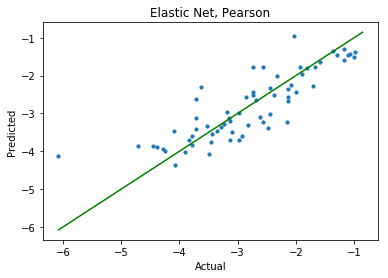

In [183]:
en = ElasticNet(alpha=5e-3,l1_ratio=0.1,max_iter=5000)

ss = StandardScaler()
enp = Pipeline([('scale',ss), ('elastic_net',en)])

test_scores = mv.repeated_KFold_pva(enp,pvsk_X.loc[:,srt_cols[:10]].values,y,repeat=5,plot_type='mean')
print(np.mean(test_scores))
plt.title('Elastic Net, Pearson')

0.7222664106552096


Text(0.5, 1.0, 'Elastic Net, Distance')

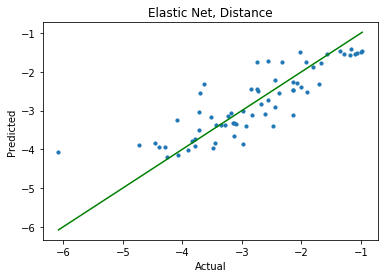

In [184]:
test_scores = mv.repeated_KFold_pva(enp,pvsk_X.loc[:,srt_cols_d[:10]].values,y,repeat=5,plot_type='mean')
print(np.mean(test_scores))
plt.title('Elastic Net, Distance')

0.6862968179136298


Text(0.5, 1.0, 'Kernel Ridge(RBF), Distance')

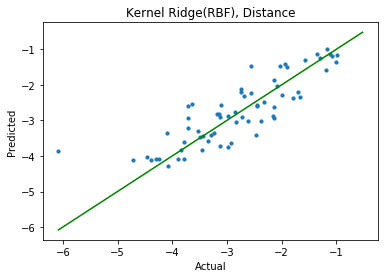

In [185]:
kr = KernelRidge(kernel='rbf',alpha=10e-3)

ss = StandardScaler()
krp = Pipeline([('scale',ss), ('kernel_ridge',kr)])

test_scores = mv.repeated_KFold_pva(krp,pvsk_X.loc[:,srt_cols_d[:10]].values,y,repeat=10,plot_type='mean')
print(np.mean(test_scores))
plt.title('Kernel Ridge(RBF), Distance')

0.702935874483274


Text(0.5, 1.0, 'Kernel Ridge (Laplacian), Distance')

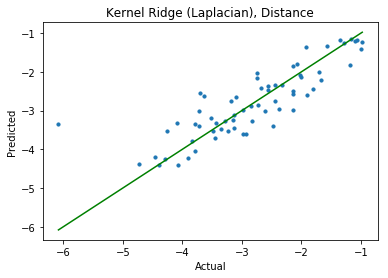

In [187]:
kr2 = KernelRidge(kernel='laplacian',alpha=10e-3)

ss = StandardScaler()
krp2 = Pipeline([('scale',ss), ('kernel_ridge',kr2)])

test_scores = mv.repeated_KFold_pva(krp2,pvsk_X.loc[:,srt_cols_d[:10]].values,y,repeat=10,plot_type='mean')
print(np.mean(test_scores))
plt.title('Kernel Ridge (Laplacian), Distance')

0.6834911237990806


Text(0.5, 1.0, 'Random Forest, Distance')

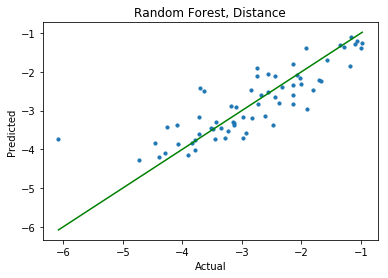

In [197]:
rf = RandomForestRegressor(n_estimators=10, max_depth=5)

ss = StandardScaler()
rfp = Pipeline([('scale',ss), ('random_forest',rf)])

test_scores = mv.repeated_KFold_pva(rfp,pvsk_X.loc[:,srt_cols_d[:10]].values,y,repeat=10,plot_type='mean')
print(np.mean(test_scores))
plt.title('Random Forest, Distance')

0.653030603076702


Text(0.5, 1.0, 'Gradient Boosting, Distance')

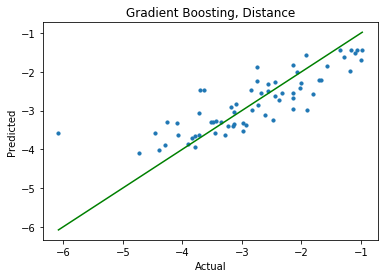

In [208]:
gb = GradientBoostingRegressor(n_estimators=10,learning_rate=0.2)

ss = StandardScaler()
gbp = Pipeline([('scale',ss), ('gradient_boosting',gb)])

test_scores = mv.repeated_KFold_pva(gbp,pvsk_X.loc[:,srt_cols_d[:10]].values,y,repeat=10,plot_type='mean')
print(np.mean(test_scores))
plt.title('Gradient Boosting, Distance')

# IV. Compare performance and interpretability

In [172]:
mg.Element('La').common_oxidation_states

(3,)